In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sionna
import scipy
from mpl_toolkits.mplot3d import Axes3D

In [2]:
FC = 8e9
BW = 20e6
D_BY_LAMBDA = 0.5
N_TX = 50
N_RX = 10
N_ROWS = 10
N_COLS = 5
N_ROWS_RX = 1
N_COLS_RX = 1
PI = np.pi
TX_LOC = [41,4,19]
# RX_LOC = [-291,-12,15]
RX0_LOC = [-291,60, 3]
RX1_LOC = [50,56, 3]
RX2_LOC = [-25,56, 3]
RX3_LOC = [-200,0, 3]
RX4_LOC = [-245,-52, 3]
RX5_LOC = [62,-52, 3]
RX6_LOC = [0,-10, 3]
RX7_LOC = [-134,97, 3]
RX8_LOC = [183,-131, 3]
RX9_LOC = [-1, 123, 3]

rx_pos = [RX0_LOC, RX1_LOC, RX2_LOC, RX3_LOC, RX4_LOC, \
          RX5_LOC, RX6_LOC, RX7_LOC, RX8_LOC, RX9_LOC]

def find_thresh(arr, N):

    if N <= 0:
        return np.max(arr) + 1
    if N >= arr.size:
        return np.min(arr)
    
    sorted_arr = np.sort(arr)[::-1]
    threshold = sorted_arr[N-1]
    
    return threshold

def create_e(n, delta, omega):
    e = np.empty((n,), dtype = np.complex64)
    for i in range(n):
        e[i] = np.exp(-1j*2*PI*delta*omega*i)
    return e * 1 / np.sqrt(n)

def create_U_P2P(n, delta,):
    U = []
    for i in range(n):
        U.append(create_e(n, delta, i / (n * delta)))
    return np.array(U)

scene = sionna.rt.load_scene(sionna.rt.scene.etoile)
scene.frequency = FC

In [3]:
scene.tx_array = sionna.rt.PlanarArray(num_rows=N_ROWS,
                             num_cols=N_COLS,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="dipole",
                             polarization="V")
#tr38901

scene.rx_array = sionna.rt.PlanarArray(num_rows=N_ROWS_RX,
                             num_cols=N_COLS_RX,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="dipole",
                             polarization="V")

tx = sionna.rt.Transmitter(name="tx",
                 position=TX_LOC,
                 display_radius=2)

scene.add(tx)

for i in range(N_RX):
    scene.remove(f"rx-{i}")
    rx = sionna.rt.Receiver(name = f"rx-{i}",
                            position = rx_pos[i],
                            display_radius =2)
    scene.add(rx)

# rx = sionna.rt.Receiver(name="rx",
#               position=RX7_LOC,
#               display_radius=2)

# scene.add(rx)

# tx.look_at(rx)

In [4]:
p_solver  = sionna.rt.PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=True,
                 seed=41)


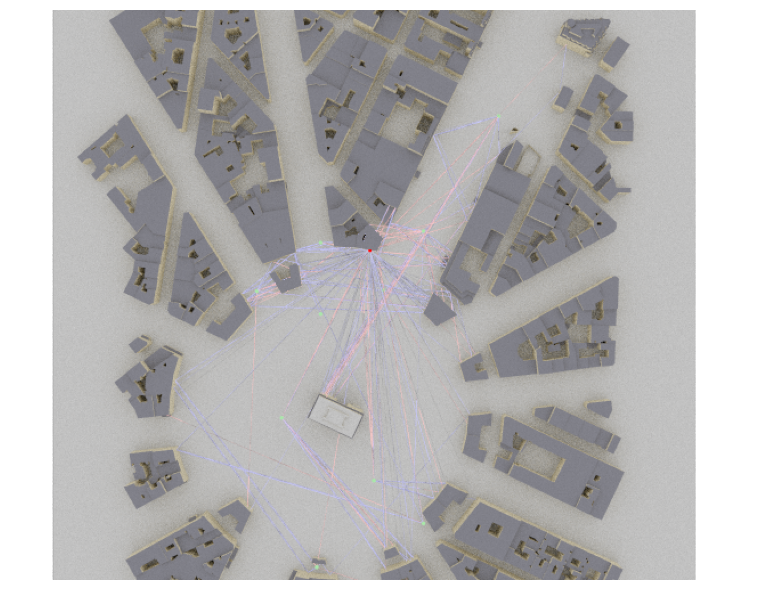

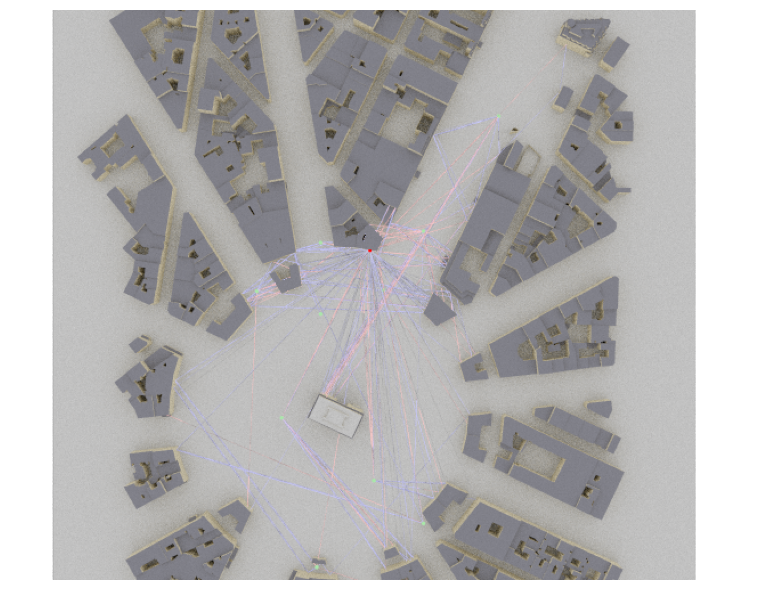

In [5]:
# scene.preview(paths=paths, clip_at=20)
# x is approx up-down, y is approx left-right
bird_cam = sionna.rt.Camera(position = [-5,-10,950], look_at = [-5,-10,0])
scene.render(camera = bird_cam, paths = paths, num_samples = 64)

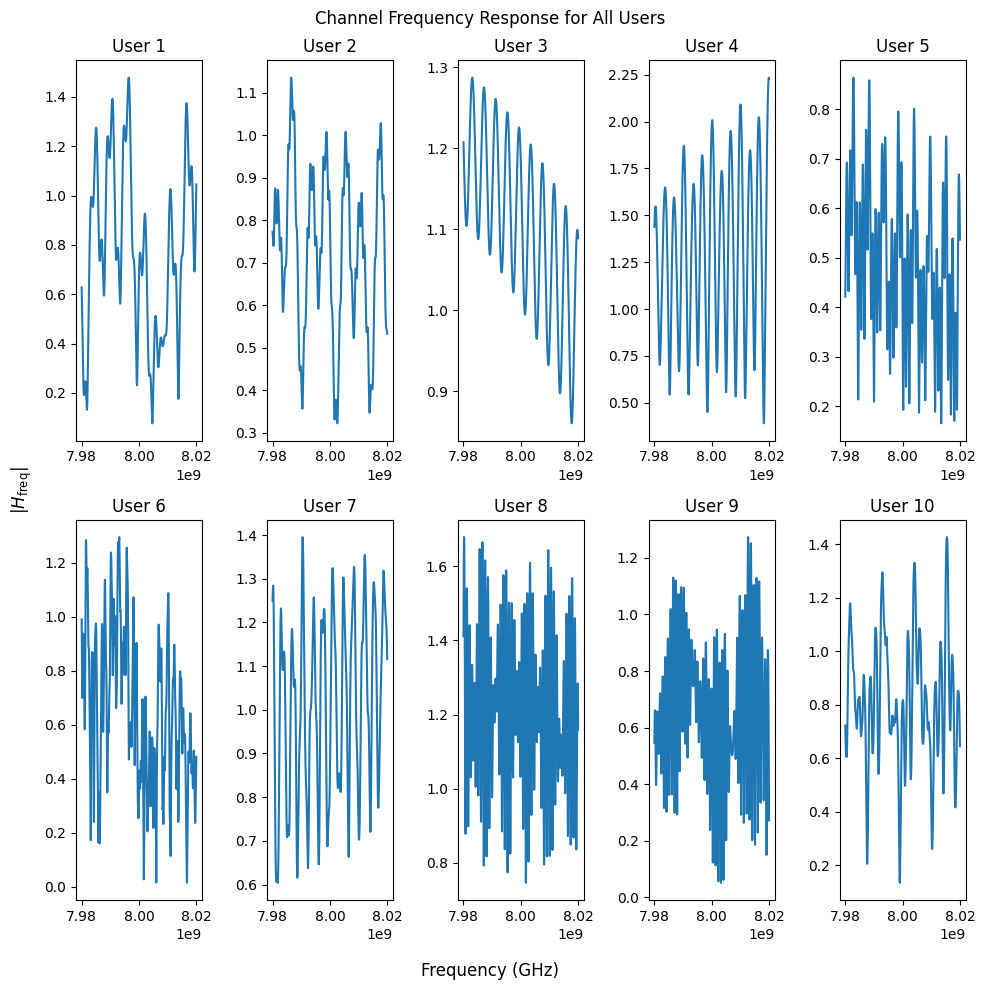

In [36]:
nfreqs = 1000
sweep_freqs = np.linspace(FC-BW, FC+BW, num=nfreqs)
h_freq_sweep = paths.cfr(frequencies=sweep_freqs,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")
abs_h_fs = np.abs(h_freq_sweep)
h_freq_FC = paths.cfr(frequencies=FC,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")
abs_h_fc = np.abs(h_freq_FC)
h_freq = h_freq_FC.reshape(10,50)
# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]

fig1, axs1 = plt.subplots(2,5, figsize = (10,10))
axs1 = axs1.flatten()

for i, ax in enumerate(axs1):
    ax.plot(sweep_freqs, abs_h_fs[i,0,0,0,0,:])
    ax.set_title(f"User {i + 1}")
    # ax.set_xlabel("Frequency (GHz)")
    # ax.set_ylabel(r"|$h_\text{freq}$|")

fig1.supxlabel("Frequency (GHz)")
fig1.supylabel(r"|$H_\text{freq}$|")
fig1.suptitle("Channel Frequency Response for All Users")
plt.tight_layout()
plt.show()

In [28]:
# zf_mat = sionna.phy.mimo.rzf_precoding_matrix(h_freq_FC)
print("h freq transpose shape: ", h_freq.T.shape)
print("h freq shape: ", h_freq.shape)
print("h freq transpose * h freq shape: ", (h_freq.T @ h_freq).shape)
print("inv h freq transpose * h freq shape: ", np.linalg.inv(h_freq.conj().T @ h_freq).shape)
zf_mat = h_freq.conj() @ np.linalg.inv(h_freq.conj().T @ h_freq)
H_zf = h_freq @ zf_mat.T
print(H_zf.shape)


h freq transpose shape:  (50, 10)
h freq shape:  (10, 50)
h freq transpose * h freq shape:  (50, 50)
inv h freq transpose * h freq shape:  (50, 50)
(10, 10)


In [35]:
Ut = create_U_P2P(N_TX, D_BY_LAMBDA)
Ur = create_U_P2P(N_RX, D_BY_LAMBDA)
print(Ur.shape)
print(Ut[0].shape)
Ha = Ur.conj().T @ H_zf


(10, 10)
(50,)
